In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
from datasets import load_dataset
from scipy.stats import entropy
from tqdm import tqdm

from calculate_kl import calculate_kl_divergence

sns.set_color_codes("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

# Constants
label_title_padding = 10
RECITATION_THRESHOLD = 10

/Users/kyle/miniconda3/envs/memorization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
figures_path = "scale+time_figures/ppl_figs"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

In [3]:
memories_path = "usvsnsp/generation-semantic-filters"
target_split = "pile_deduped_12b"
pile_frame = load_dataset(memories_path, split=target_split).to_pandas()
pile_frame["Memorized"] = pile_frame["memorization_score"] >= 1
print(f"Loaded {len(pile_frame)} examples from {memories_path}/{target_split}")
pile_frame.head(1)

Loaded 5000000 examples from usvsnsp/generation-semantic-filters/pile_deduped_12b


,sequence_id,tokens,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,...,0_8_templates,0_9_templates,huffman_coding_length,memorization_score,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Memorized
0,3195,"[273, 253, 6115, 1159, 275, 5238, 905, 16314, ...",of the Green function in Section \[proof2\].\...,False,False,2,11740996961,1.737210e+09,466618,91844186.5,...,1,1,5.036364,0.0,3195,2.480469,4.364043,2.667871,11.642706,False


In [4]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

pile_frame["Category"] = pile_frame.progress_apply(get_category, axis=1)
pile_frame["Category"].value_counts()

100%|██████████| 5000000/5000000 [00:09<00:00, 524634.15it/s]


Category
Not Memorized     4946005
Recitation          41880
Recollection        11130
Reconstruction        985
Name: count, dtype: int64

In [5]:
pile_frame["is_code"] = pile_frame["nl_scores"].progress_apply(lambda x: x <= 0.45)

100%|██████████| 5000000/5000000 [00:01<00:00, 4880844.57it/s]


generation_perplexity                                          \
                          count      mean       std       min       25%   
Memorized                                                                 
False                 4839838.0  3.419192  1.620504  1.010721  2.333272   
True                    12382.0  1.026164  0.024413  1.000009  1.007694   

                                          
                50%       75%        max  
Memorized                                 
False      3.192831  4.166949  79.729668  
True       1.019247  1.037334   1.200819

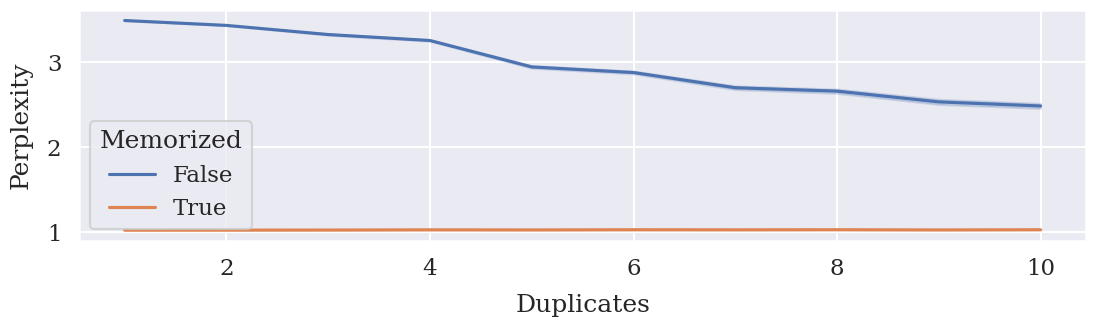

In [6]:
plotting_frame = pile_frame[pile_frame["sequence_duplicates"] <= 10]
display(plotting_frame[["Memorized", "generation_perplexity"]].groupby("Memorized").describe())

# Plot lineplot
sns.lineplot(data=plotting_frame, x="sequence_duplicates", y="generation_perplexity", hue="Memorized", errorbar="ci")

# y label is "Perplexity" and x label is "Duplicates"
plt.xlabel("Duplicates", labelpad=label_title_padding)
plt.ylabel("Perplexity", labelpad=label_title_padding)

# set figure dimensions
plt.gcf().set_size_inches(13, 3)

# log x axis
# plt.xscale("log")

In [7]:
max_memorized_perplexity = plotting_frame[plotting_frame["Memorized"] == False]["generation_perplexity"].quantile(0.99)
max_memorized_perplexity

8.445495252609252

In [8]:
examples_below_ppl_thrrshold = plotting_frame[plotting_frame["generation_perplexity"] <= max_memorized_perplexity]
examples_below_ppl_thrrshold.value_counts("Memorized", normalize=True)

Memorized
False    0.997422
True     0.002578
Name: proportion, dtype: float64

## Memories vs Non-Memories

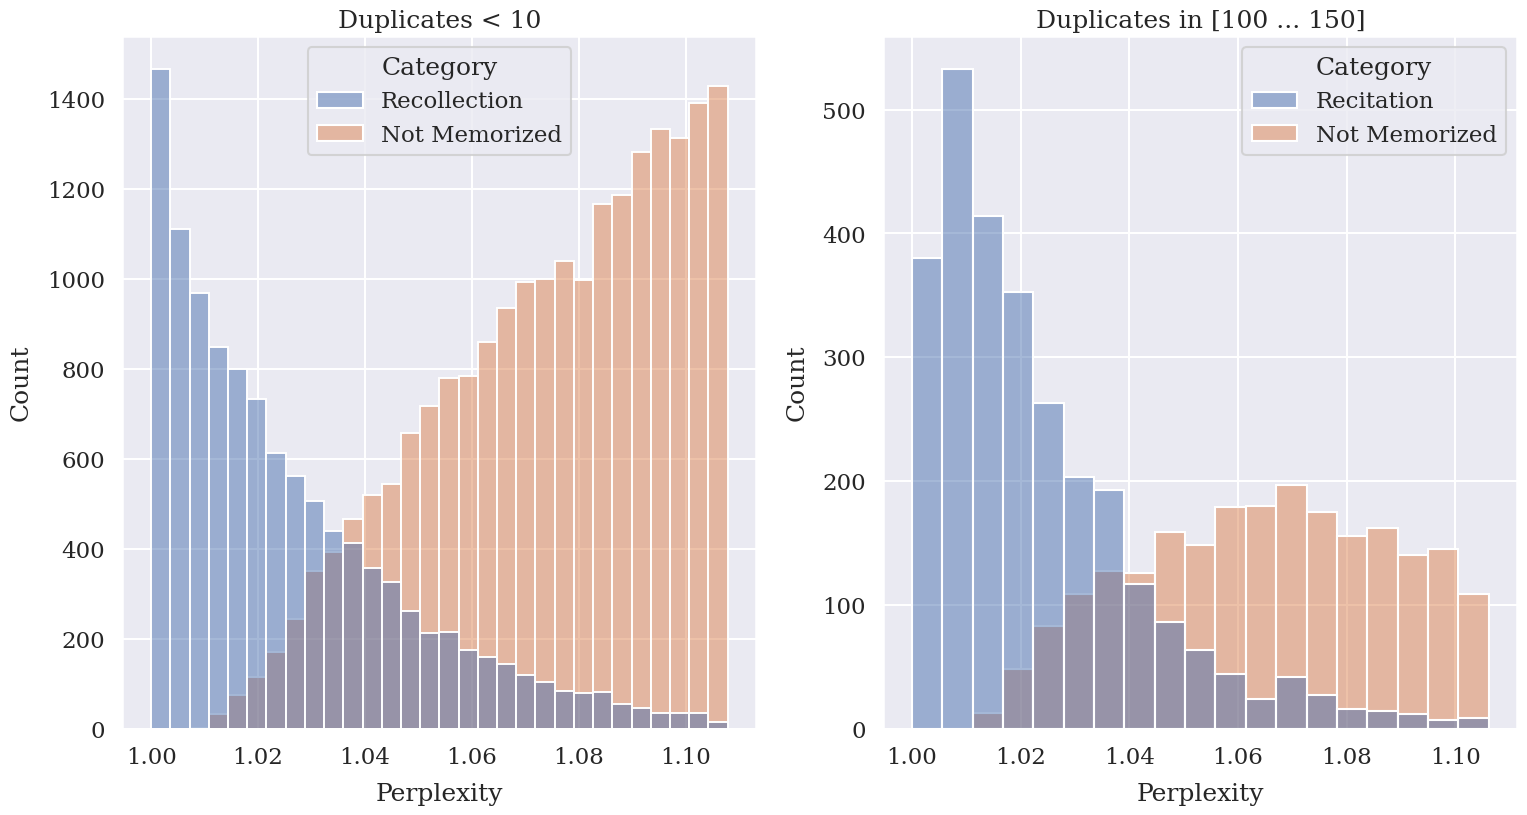

In [9]:
# TWO HISTOGRAMS
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

plotting_frames = [
    # duplicates less than 10
    pile_frame[pile_frame["sequence_duplicates"] < 10],
    # duplicates in the range of 100 ... 150
    pile_frame[(pile_frame["sequence_duplicates"] >= 100) & (pile_frame["sequence_duplicates"] <= 150)]
]

for i, plotting_frame in enumerate(plotting_frames):
    p95_memeorization_ppl = plotting_frame[plotting_frame["Memorized"] == True]["generation_perplexity"].quantile(0.99)
    hist_data_12b = plotting_frame[plotting_frame["generation_perplexity"] <= p95_memeorization_ppl]
    # filter out Reconstructions
    hist_data_12b = hist_data_12b[hist_data_12b["Category"] != "Reconstruction"]

    # hist should be transparent to show both
    sns.histplot(data=hist_data_12b, x="generation_perplexity", hue="Category", multiple="layer", ax=ax[i])

    ax[i].set_xlabel("Perplexity", labelpad=label_title_padding)
    ax[i].set_ylabel("Count", labelpad=label_title_padding)

    # set titles
    if i == 0:
        ax[i].set_title("Duplicates < 10")
        # remove legend
        # ax[i].get_legend().remove()
    else:
        ax[i].set_title("Duplicates in [100 ... 150]")
        # center legend below both plots
        # ax[i].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15), shadow=True, ncol=2, labels=["Memorized", "Not Memorized"], frameon=False)

# add padding between plots
# plt.tight_layout()

## Only Memories by Category

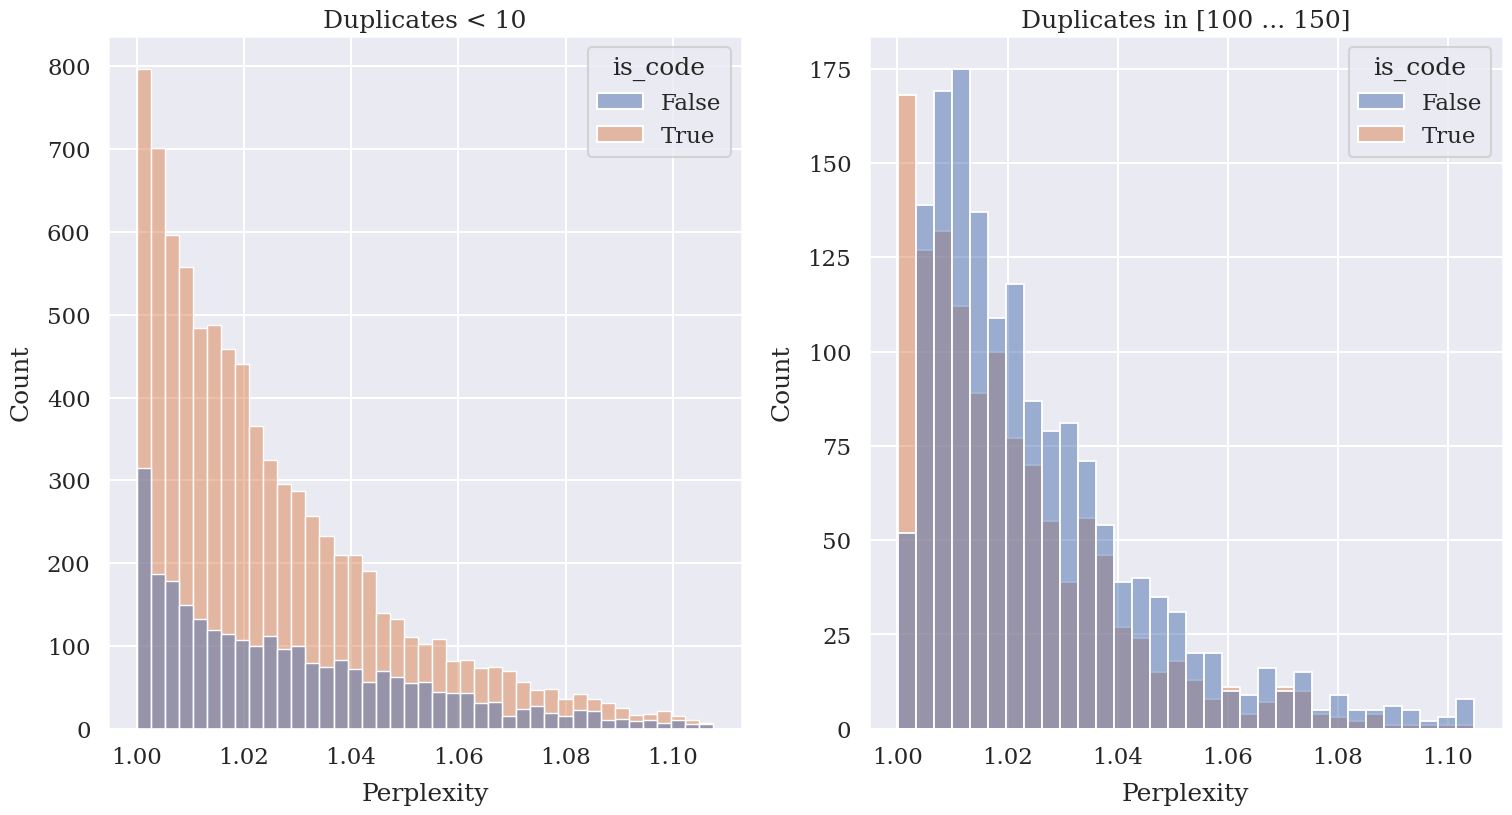

In [10]:
# TWO HISTOGRAMS
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

plotting_frames_memorized = [
    # duplicates less than 10
    pile_frame[(pile_frame["sequence_duplicates"] < 10) & (pile_frame["Memorized"] == True)],
    # duplicates in the range of 100 ... 150
    pile_frame[(pile_frame["sequence_duplicates"] >= 100) & (pile_frame["sequence_duplicates"] <= 150) & (pile_frame["Memorized"] == True)]
]

for i, plotting_frame in enumerate(plotting_frames_memorized):
    p95_memeorization_ppl = plotting_frame[plotting_frame["Memorized"] == True]["generation_perplexity"].quantile(0.99)
    hist_data_12b = plotting_frame[plotting_frame["generation_perplexity"] <= p95_memeorization_ppl]
    # filter out Reconstructions
    hist_data_12b = hist_data_12b[hist_data_12b["Category"] != "Reconstruction"]

    # hist should be transparent to show both
    sns.histplot(data=hist_data_12b, x="generation_perplexity", hue="is_code", multiple="layer", ax=ax[i])

    ax[i].set_xlabel("Perplexity", labelpad=label_title_padding)
    ax[i].set_ylabel("Count", labelpad=label_title_padding)

    # set titles
    if i == 0:
        ax[i].set_title("Duplicates < 10")
        # remove legend
        # ax[i].get_legend().remove()
    else:
        ax[i].set_title("Duplicates in [100 ... 150]")
        # center legend below both plots
        # ax[i].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15), shadow=True, ncol=2, labels=["Memorized", "Not Memorized"], frameon=False)

# add padding between plots
# plt.tight_layout()

## Memories vs Non-Memories by Dataset

In [11]:
memories_dataset = load_dataset(memories_path, split="memories_deduped_12b").to_pandas()
memories_dataset["Memorized"] = True
memories_dataset.head()

,sequence_id,tokens,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,...,0_8_templates,0_9_templates,huffman_coding_length,memorization_score,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Memorized
0,1260,"[15, 681, 16, 1825, 77, 16, 285, 1239, 352, 10...",.com/apsl/ and read it before using this\n * f...,False,False,2476,11740996961,2.490852e+09,1210739,331265808.0,...,10,2,4.698413,1.0,1260,0.509766,1.239420,1.003330,1.243547,True
1,7799,"[61, 19104, 61, 565, 1559, 61, 7836, 18, 61, 7...",\plain\intbl\cf1\f51\fs20\ql \~\cell\pard\plai...,False,False,38151,944746570,2.763761e+08,1033026,136955836.0,...,34,0,4.327869,1.0,7799,0.645996,1.821424,1.012688,1.844534,True
2,14967,"[2490, 50276, 28873, 15, 2490, 50276, 26906, 1...",\n 502. \n 503. \n 504. \n 505. \n 506. ...,True,False,2134,10346382453,2.779552e+09,1010832,385281005.0,...,78,4,2.953125,1.0,14967,0.630371,1.191791,1.000893,1.192856,True
3,15064,"[29, 965, 31, 12641, 64, 56, 1838, 9278, 64, 1...",<li>ERROR_WIDGET_DISPOSED - if the receiver ha...,False,False,700,11740996961,9.946212e+08,527839,271847545.0,...,0,0,5.044444,1.0,15064,0.532715,2.064291,1.006569,2.077852,True
4,15428,"[18, 2730, 2551, 31, 42, 36996, 308, 2277, 119...",1><span>I LOVE TOMATO!!!!</span></h1><br>\r\n ...,False,False,21,944746570,2.261272e+08,868826,85290843.0,...,0,0,5.000000,1.0,15428,0.754883,2.547602,1.039926,2.649317,True


In [12]:
all_memories_and_sample = pd.concat([
    pile_frame[pile_frame["Memorized"] == False],
    memories_dataset]
    ).drop_duplicates(subset=["sequence_id"])

In [13]:
all_memories_and_sample["Memorized"].value_counts()

Memorized
False    4946005
True     1871215
Name: count, dtype: int64

In [14]:
all_memories_plotting_frames = [
    all_memories_and_sample[all_memories_and_sample["sequence_duplicates"] < 10],
    all_memories_and_sample[(all_memories_and_sample["sequence_duplicates"] >= 100) & (all_memories_and_sample["sequence_duplicates"] <= 150)]
]

all_memories_plotting_frames[0].head(1)

,sequence_id,tokens,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,...,huffman_coding_length,memorization_score,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Memorized,Category,is_code
0,3195,"[273, 253, 6115, 1159, 275, 5238, 905, 16314, ...",of the Green function in Section \[proof2\].\...,False,False,2,11740996961,1.737210e+09,466618,91844186.5,...,5.036364,0.0,3195,2.480469,4.364043,2.667871,11.642706,False,Not Memorized,False


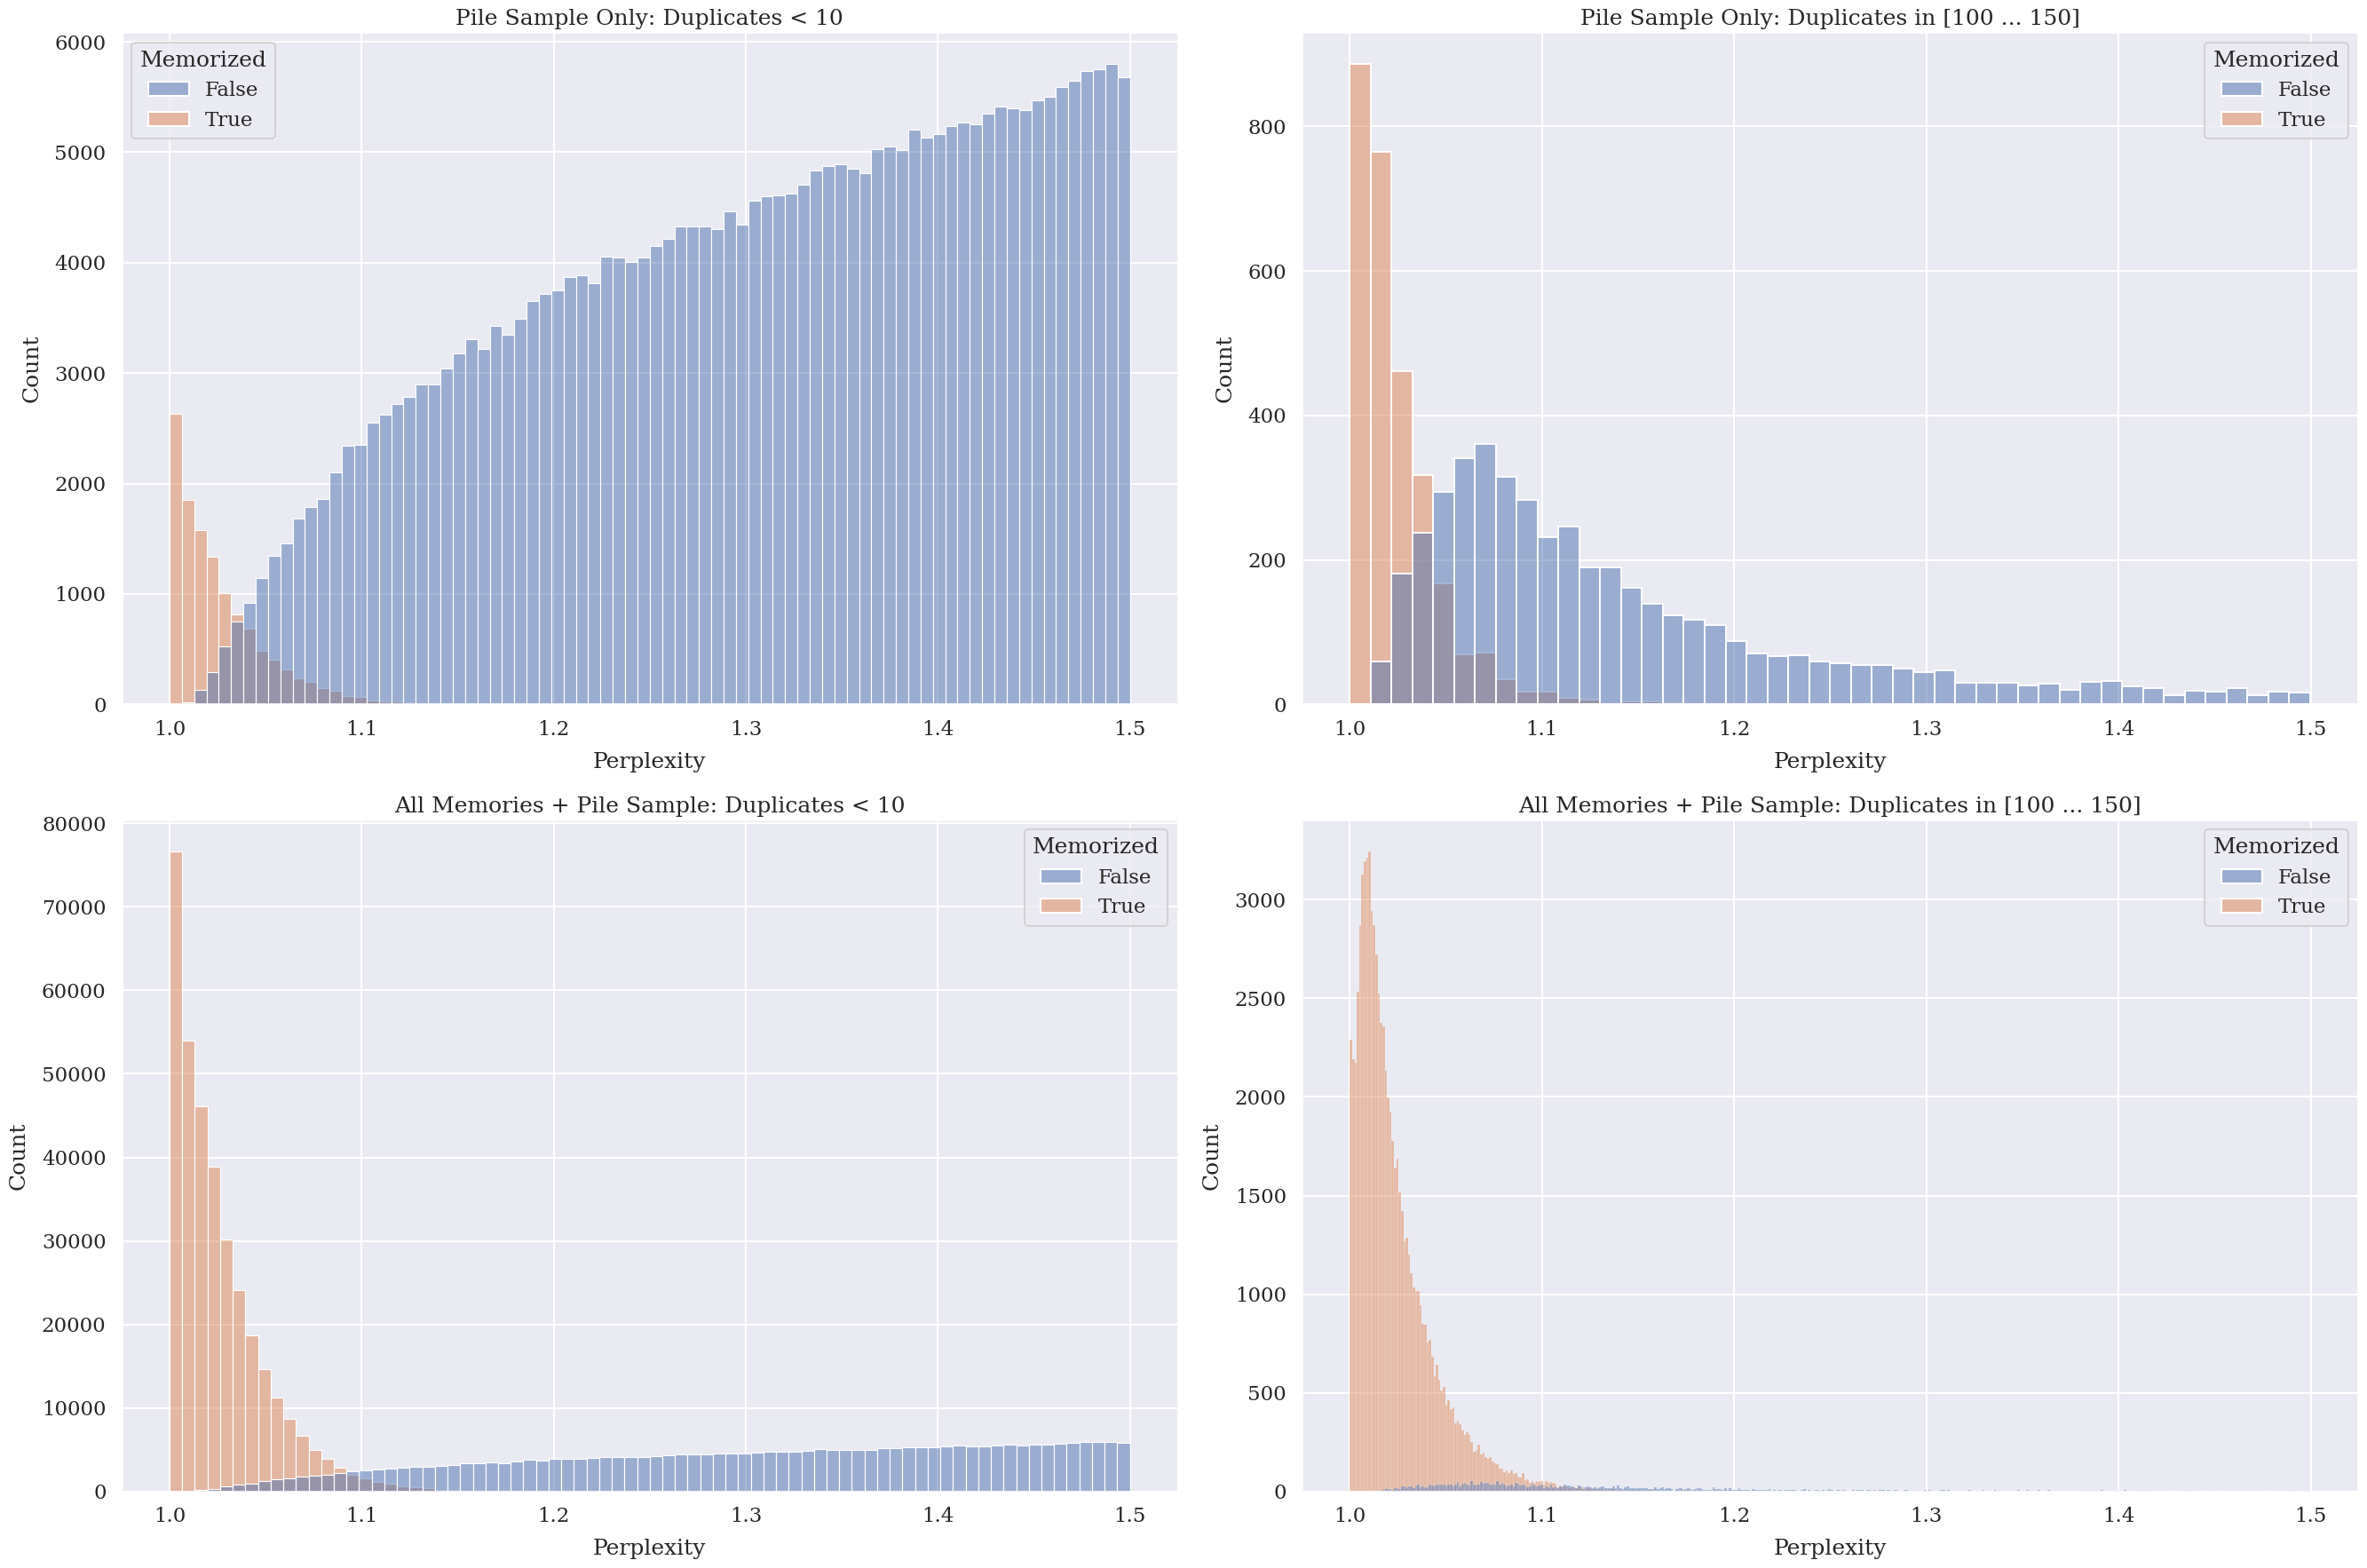

In [15]:
# TWO HISTOGRAMS across two rows
fig, ax = plt.subplots(2, 2, figsize=(27, 18))
for row_index in range(2):
    for col_index, plotting_frame in enumerate(plotting_frames if row_index == 0 else all_memories_plotting_frames):
        # p95_mem_ppl = plotting_frame[plotting_frame["Memorized"] == True]["generation_perplexity"].quantile(0.95)
        p95_mem_ppl = 1.5
        hist_data_12b = plotting_frame[plotting_frame["generation_perplexity"] <= p95_mem_ppl]

        # hist should be transparent to show both
        sns.histplot(data=hist_data_12b, x="generation_perplexity", hue="Memorized", multiple="layer", ax=ax[row_index, col_index])

        # Set Labels
        ax[row_index, col_index].set_xlabel("Perplexity", labelpad=label_title_padding)
        ax[row_index, col_index].set_ylabel("Count", labelpad=label_title_padding)

        # Set centered row titles. First row is "Pile Sample Only" and second row is "All Memories + Pile Sample"
        title_prefix = ""
        if row_index == 0:
            title_prefix = "Pile Sample Only:"
        else:
            title_prefix = "All Memories + Pile Sample:"

        # set titles
        if col_index == 0:
            ax[row_index, col_index].set_title(f"{title_prefix} Duplicates < 10")
        else:
            ax[row_index, col_index].set_title(f"{title_prefix} Duplicates in [100 ... 150]")

# add padding
plt.tight_layout()

## KL Divergence

In [16]:
# bucket sequence duplicates in buckets of 5 by rounding down
pile_frame_rounded = pile_frame.copy()
bin_size = 1
pile_frame_rounded["sequence_duplicates"] = pile_frame_rounded["sequence_duplicates"].apply(lambda x: x - (x % bin_size))
pile_frame_rounded["sequence_duplicates"].value_counts().sort_index()

sequence_duplicates
1          1324363
2          3082552
3           148861
4           162744
5            40383
            ...   
4291073         84
4291074         74
4291076         82
4291088         62
5480569         70
Name: count, Length: 9760, dtype: int64

100%|██████████| 1000/1000 [00:06<00:00, 158.71it/s]


,Duplicates,KL Divergence
0,1,0.111217
1,2,0.112842
2,3,0.163151
3,4,0.170611
4,5,0.186246


,Duplicates,KL Divergence
0,1,0.107754
1,2,0.109514
2,3,0.156081
3,4,0.164238
4,5,0.188575


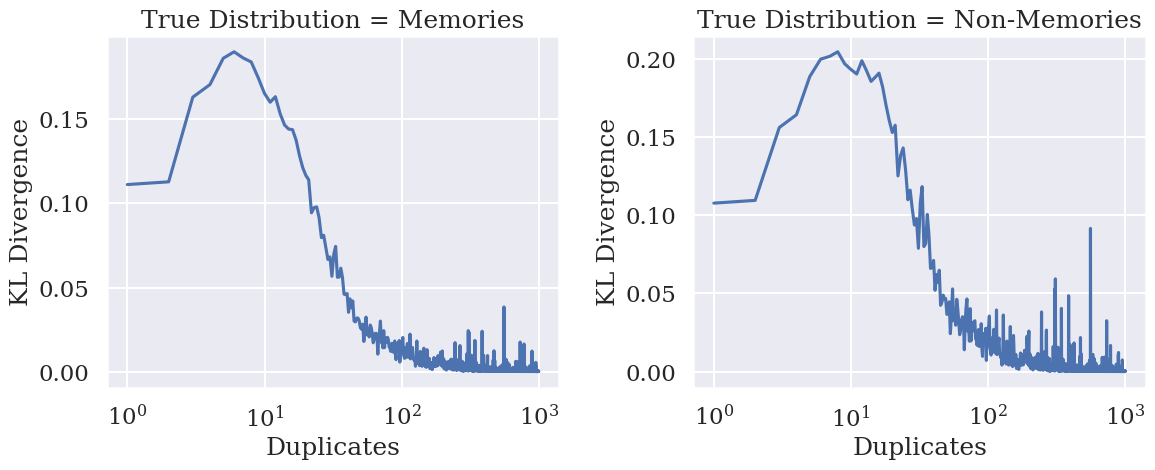

In [17]:
memory_divergences = []
nonmemory_divergences = []
duplications= np.arange(0, 1000, bin_size)
for duplication_count in tqdm(duplications):
    if duplication_count == 0:
        continue

    examples_at_duplication_count = all_memories_and_sample[all_memories_and_sample["sequence_duplicates"] == duplication_count]
    memories_at_duplication_count = memories_dataset[memories_dataset["sequence_duplicates"] == duplication_count]["generation_perplexity"]
    non_memories_at_duplication_count = all_memories_and_sample[all_memories_and_sample["sequence_duplicates"] == duplication_count]["generation_perplexity"]
    
    # downsample to calculate kl divergence
    balance_size = min(len(memories_at_duplication_count), len(non_memories_at_duplication_count))
    memories_at_duplication_count = memories_at_duplication_count.sample(balance_size)
    non_memories_at_duplication_count = non_memories_at_duplication_count.sample(balance_size)

    # generate kl divergence in perplexity with memories as the true distribution
    kl_divergence = entropy(memories_at_duplication_count, non_memories_at_duplication_count)
    memory_divergences.append({
        "Duplicates": duplication_count,
        "KL Divergence": kl_divergence
    })

    # generate kl divergence in perplexity with non-memories as the true distribution
    kl_divergence = entropy(non_memories_at_duplication_count, memories_at_duplication_count)
    nonmemory_divergences.append({
        "Duplicates": duplication_count,
        "KL Divergence": kl_divergence
    })

memory_divergences_frame = pd.DataFrame(memory_divergences)
nonmemory_divergences_frame = pd.DataFrame(nonmemory_divergences)

head_size = 5
display(memory_divergences_frame.head(head_size))
display(nonmemory_divergences_frame.head(head_size))

# plot both frames
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(data=memory_divergences_frame, x="Duplicates", y="KL Divergence", ax=ax[0])
ax[0].set_title("True Distribution = Memories")

sns.lineplot(data=nonmemory_divergences_frame, x="Duplicates", y="KL Divergence", ax=ax[1])
ax[1].set_title("True Distribution = Non-Memories")

# add padding
plt.tight_layout()

# log x axis
ax[0].set_xscale("log")
ax[1].set_xscale("log")

fig.savefig(f"{figures_path}/kl_divergence_generation_ppl.pdf")

## KL Divergence Bootstrapped

In [18]:
from scipy.integrate import quad

In [22]:
def calculate_kl_divergence(all_memories_and_sample, memories_dataset, duplication_count):
    all_memories_bootstrap_sample = all_memories_and_sample[all_memories_and_sample["sequence_duplicates"] == duplication_count].sample(frac=1, replace=True)
    memories_at_duplication_count = memories_dataset[memories_dataset["sequence_duplicates"] == duplication_count]["generation_perplexity"]
    non_memories_at_duplication_count = all_memories_bootstrap_sample[all_memories_bootstrap_sample["sequence_duplicates"] == duplication_count]["generation_perplexity"]

    # downsample to calculate kl divergence
    balance_size = min(len(memories_at_duplication_count), len(non_memories_at_duplication_count))
    memories_at_duplication_count = memories_at_duplication_count.sample(balance_size)
    non_memories_at_duplication_count = non_memories_at_duplication_count.sample(balance_size)

    # softmax
    memories_at_duplication_count = memories_at_duplication_count / memories_at_duplication_count.sum()
    non_memories_at_duplication_count = non_memories_at_duplication_count / non_memories_at_duplication_count.sum()

    # generate kl divergence in perplexity with memories as the true distribution
    kl_divergence = entropy(memories_at_duplication_count, non_memories_at_duplication_count)
    return {
        "Duplicates": duplication_count,
        "KL Divergence": kl_divergence
    }

bootstrapped_memory_divergences = []
duplications= np.arange(1, 1000, bin_size)
for bootstrap_index in tqdm(range(10)):
    for duplication_count in duplications:
        # with mp.Pool(mp.cpu_count()) as pool:
        #     results = list(pool.imap(calculate_kl_divergence, [duplication_count] * 100))
        #     bootstrapped_memory_divergences.extend(results)
        # break
        bootstrapped_memory_divergences.append(calculate_kl_divergence(all_memories_and_sample, memories_dataset, duplication_count))

bootstrapped_memory_divergences


100%|██████████| 10/10 [00:59<00:00,  5.94s/it]


[{'Duplicates': 1, 'KL Divergence': 0.11344916},
 {'Duplicates': 2, 'KL Divergence': 0.11186638},
 {'Duplicates': 3, 'KL Divergence': 0.16357344},
 {'Duplicates': 4, 'KL Divergence': 0.1690037},
 {'Duplicates': 5, 'KL Divergence': 0.182677},
 {'Duplicates': 6, 'KL Divergence': 0.19373998},
 {'Duplicates': 7, 'KL Divergence': 0.18295152},
 {'Duplicates': 8, 'KL Divergence': 0.17994699},
 {'Duplicates': 9, 'KL Divergence': 0.17194691},
 {'Duplicates': 10, 'KL Divergence': 0.17019528},
 {'Duplicates': 11, 'KL Divergence': 0.16651145},
 {'Duplicates': 12, 'KL Divergence': 0.16719943},
 {'Duplicates': 13, 'KL Divergence': 0.14511691},
 {'Duplicates': 14, 'KL Divergence': 0.13936763},
 {'Duplicates': 15, 'KL Divergence': 0.1420415},
 {'Duplicates': 16, 'KL Divergence': 0.13801712},
 {'Duplicates': 17, 'KL Divergence': 0.11922179},
 {'Duplicates': 18, 'KL Divergence': 0.12524658},
 {'Duplicates': 19, 'KL Divergence': 0.1215579},
 {'Duplicates': 20, 'KL Divergence': 0.11974018},
 {'Duplicates'

In [23]:
bootstrapped_memory_divergences_frame = pd.DataFrame(bootstrapped_memory_divergences)

# sort by duplicates
bootstrapped_memory_divergences_frame = bootstrapped_memory_divergences_frame.sort_values(by="Duplicates")
bootstrapped_memory_divergences_frame

,Duplicates,KL Divergence
0,1,0.113449
7992,1,0.112267
3996,1,0.111892
4995,1,0.111335
999,1,0.112480
...,...,...
2996,999,0.000378
1997,999,0.000177
998,999,0.000196
8990,999,0.000113


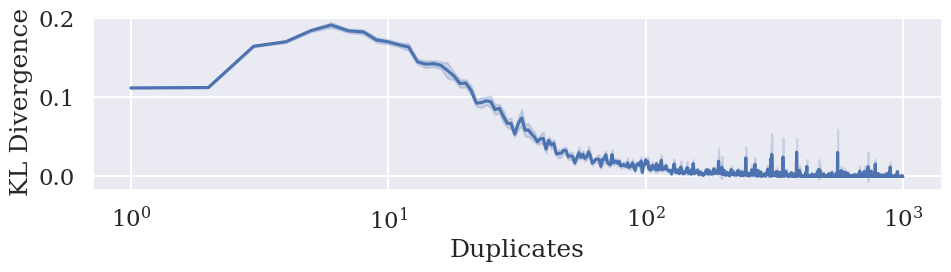

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

sns.lineplot(data=bootstrapped_memory_divergences_frame, x="Duplicates", y="KL Divergence", ax=ax, errorbar="sd")
# ax.set_title("True Distribution = Memories")

# add padding
plt.tight_layout()

# log x axis
ax.set_xscale("log")

# remove extra padding
plt.subplots_adjust(top=0.9)

fig.savefig(f"{figures_path}/kl_divergence_generation_ppl_bootstrapped.pdf", bbox_inches="tight")